In [1]:
%load_ext autoreload

from dotenv import load_dotenv

# Load environment variables from .env file
load_dotenv("../.env")

True

In [80]:
%autoreload 2

import json
from pathlib import Path

import tqdm
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import rasterio
import seaborn as sns
import yaml
from PIL import Image
import datetime

from estuary.util import false_color, masked_contrast_stretch, broad_band
from estuary.model.data import parse_dt_from_pth

In [89]:
all_clear_dfs = []
all_dfs = []
all_to_download_dfs = []

def parse_dt_from_asset_id(asset_id: str) -> datetime.datetime:
    """Parse acquisition datetime from file stem prefix YYYYMMDD_HHMMSS_*"""
    datetime_str = "_".join(asset_id.split("_")[:2])
    date_format = "%Y%m%d_%H%M%S"
    return datetime.datetime.strptime(datetime_str, date_format)

for region_p in Path("/Volumes/x10pro/estuary/ca_grids").iterdir():
    region = region_p.stem
    for year in range(2017, 2026):
        for month in range(1, 13):
            for dove in ["superdove", "dove"]:
                pth = Path(f"/Volumes/x10pro/estuary/ca_all/{dove}/results") / str(year) / str(month) / str(region) / "clear_images_to_download.csv"
                if not pth.exists():
                    continue
                df = pd.read_csv(pth)
                df["dove"] = dove
                df["region"] = int(region)
                df["year"] = int(year)
                df["month"] = int(month)
                df["acquired"] = df.asset_id.apply(parse_dt_from_asset_id) 

                all_clear_dfs.append(df)

                pth = Path(f"/Volumes/x10pro/estuary/ca_all/{dove}/results") / str(year) / str(month) / str(region) / "images_to_download.csv"
                if not pth.exists():
                    continue
                ddf = pd.read_csv(pth)
                ddf["dove"] = dove
                ddf["region"] = int(region)
                ddf["year"] = int(year)
                ddf["month"] = int(month)
                ddf["acquired"] = df.asset_id.apply(parse_dt_from_asset_id)
                downloaded_asset_ids = ddf.asset_id.tolist()
                ddf = ddf[ddf.asset_id.isin(df.asset_id)].copy()

                all_dfs.append(ddf)

                all_to_download_dfs.append(df[~df.asset_id.isin(downloaded_asset_ids)].copy())

clear_df = pd.concat(all_clear_dfs)
clear_df = clear_df.drop(columns=['ordered_idx', 'capture_datetime'])

available_df = pd.concat(all_dfs)
available_df = available_df.drop(columns=['ordered_idx', 'capture_datetime'])

to_download_df = pd.concat(all_to_download_dfs)

print(len(clear_df), len(available_df))

clear_df.head(3)

196450 140371


asset_id  clear_coverge_pct  intersection_pct  pct_adding  \
0  20170528_174342_1009             0.9986               1.0     99.8591   
1  20170527_174413_0f34             0.9986               1.0     99.8591   
2  20170513_174924_0e19             0.9986               1.0     99.8591   

   include_image  dove  region  year  month            acquired  
0           True  dove      16  2017      5 2017-05-28 17:43:42  
1           True  dove      16  2017      5 2017-05-27 17:44:13  
2           True  dove      16  2017      5 2017-05-13 17:49:24

In [32]:
ss_df = pd.read_csv("/Volumes/x10pro/estuary/skysat/labels.csv")
ss_df["acquired"] = ss_df.source_tif.apply(lambda a: parse_dt_from_pth(Path(a)))
ss_df["month"] = ss_df.acquired.dt.month
ss_df["year"] = ss_df.acquired.dt.year
ss_df = ss_df.drop(columns=['source_jpeg'])
ss_df = ss_df[ss_df.label != "unsure"].copy()
ss_df.head()

region                                         source_tif   label  \
0      35  /Volumes/x10pro/estuary/skysat/results/2022/35...  closed   
1      35  /Volumes/x10pro/estuary/skysat/results/2023/35...    open   
2      35  /Volumes/x10pro/estuary/skysat/results/2019/35...    open   
3      35  /Volumes/x10pro/estuary/skysat/results/2019/35...  closed   
4      35  /Volumes/x10pro/estuary/skysat/results/2021/35...  closed   

             acquired instrument  month  year  
0 2022-06-15 18:07:04     skysat      6  2022  
1 2023-04-02 21:21:05     skysat      4  2023  
2 2019-06-08 18:38:26     skysat      6  2019  
3 2019-11-02 21:40:24     skysat     11  2019  
4 2021-05-29 18:42:34     skysat      5  2021

In [33]:
tmp = clear_df.merge(ss_df, on="region", suffixes=("_dd", "_ss"))
tmp["acquired_diff"] = (tmp.acquired_dd - tmp.acquired_ss).abs()
tol = pd.Timedelta("10h")
mask = (tmp["acquired_dd"] >= tmp["acquired_ss"] - tol) & (
    tmp["acquired_dd"] <= tmp["acquired_ss"] + tol
)
dove_pairs = tmp.loc[mask].sort_values(["region", "acquired_dd", "acquired_ss"])

dove_pairs = dove_pairs.drop(columns=["year_ss", "month_ss"]).rename(
    columns={"year_dd": "year", "month_dd": "month"}
)

dove_pairs

asset_id  clear_coverge_pct  intersection_pct  \
2853637     20200801_161237_0f2e             1.0071               1.0   
2853568     20200806_175246_0e26             1.0071               1.0   
2853792     20200806_175247_0e26             1.0071               1.0   
2853806  20200806_184126_74_1060             1.0071               1.0   
2853720     20200830_160451_1049             0.0000               1.0   
...                          ...                ...               ...   
1162125  20220314_180755_87_2484             1.0025               1.0   
1203198  20240203_182612_73_248b             0.0000               1.0   
1203124  20240203_182614_70_248b             0.0000               1.0   
1222511  20241020_184013_52_24df             1.0025               1.0   
1221253  20241020_184244_67_24d7             1.0025               1.0   

         pct_adding  include_image       dove  region  year  month  \
2853637    100.7112           True       dove      11  2020      8   
2853568    100.7112           True       dove      11  2020      8   
2853792    100.7112           True       dove      11  2020      8   
2853806    100.7112           True       dove      11  2020      8   
2853720      0.0000          False       dove      11  2020      8   
...             ...            ...        ...     ...   ...    ...   
1162125    100.2510           True  superdove    2163  2022      3   
1203198      0.0000          False  superdove    2163  2024      2   
1203124      0.0000          False  superdove    2163  2024      2   
1222511    100.2510           True  superdove    2163  2024     10   
1221253    100.2510           True  superdove    2163  2024     10   

                acquired_dd  \
2853637 2020-08-01 16:12:37   
2853568 2020-08-06 17:52:46   
2853792 2020-08-06 17:52:47   
2853806 2020-08-06 18:41:26   
2853720 2020-08-30 16:04:51   
...                     ...   
1162125 2022-03-14 18:07:55   
1203198 2024-02-03 18:26:12   
1203124 2024-02-03 18:26:14   
1222511 2024-10-20 18:40:13   
1221253 2024-10-20 18:42:44   

                                                source_tif label  \
2853637  /Volumes/x10pro/estuary/skysat/results/2020/11...  open   
2853568  /Volumes/x10pro/estuary/skysat/results/2020/11...  open   
2853792  /Volumes/x10pro/estuary/skysat/results/2020/11...  open   
2853806  /Volumes/x10pro/estuary/skysat/results/2020/11...  open   
2853720  /Volumes/x10pro/estuary/skysat/results/2020/11...  open   
...                                                    ...   ...   
1162125  /Volumes/x10pro/estuary/skysat/results/2022/21...  open   
1203198  /Volumes/x10pro/estuary/skysat/results/2024/21...  open   
1203124  /Volumes/x10pro/estuary/skysat/results/2024/21...  open   
1222511  /Volumes/x10pro/estuary/skysat/results/2024/21...  open   
1221253  /Volumes/x10pro/estuary/skysat/results/2024/21...  open   

                acquired_ss instrument   acquired_diff  
2853637 2020-08-01 18:45:36     skysat 0 days 02:32:59  
2853568 2020-08-06 21:26:39     skysat 0 days 03:33:53  
2853792 2020-08-06 21:26:39     skysat 0 days 03:33:52  
2853806 2020-08-06 21:26:39     skysat 0 days 02:45:13  
2853720 2020-08-30 21:12:03     skysat 0 days 05:07:12  
...                     ...        ...             ...  
1162125 2022-03-14 21:37:14     skysat 0 days 03:29:19  
1203198 2024-02-03 17:10:39     skysat 0 days 01:15:33  
1203124 2024-02-03 17:10:39     skysat 0 days 01:15:35  
1222511 2024-10-20 17:08:46     skysat 0 days 01:31:27  
1221253 2024-10-20 17:08:46     skysat 0 days 01:33:58  

[1690 rows x 15 columns]

In [34]:
# strip the _3B_udm2 from the file name
# e.g. 20230901_182511_53_2486_3B_udm2.tif
def cleaned_asset_id(filename: str) -> str:
    filepath = Path(filename)
    return filepath.stem.split("_3B_")[0]

dove_labels = pd.read_csv("/Volumes/x10pro/estuary/dove/labels.csv")
dove_labels["acquired"] = pd.to_datetime(dove_labels["acquired"], errors="coerce")
dove_labels["asset_id"] = dove_labels.source_tif.apply(cleaned_asset_id)
dove_labels["year"] = dove_labels.acquired.dt.year
dove_labels["month"] = dove_labels.acquired.dt.month
dove_labels.head(3)

region                                         source_tif   label  \
0      65  /Volumes/x10pro/estuary/superdove/results/2022...  closed   
1      65  /Volumes/x10pro/estuary/superdove/results/2022...  closed   
2      65  /Volumes/x10pro/estuary/superdove/results/2022...  closed   

             acquired instrument                 asset_id  year  month  
0 2022-09-03 18:37:27       dove  20220903_183727_56_2489  2022      9  
1 2022-11-02 18:35:56       dove  20221102_183556_95_2498  2022     11  
2 2022-07-10 18:21:59       dove  20220710_182159_83_2251  2022      7

In [88]:
cloudy_downloads = {}
clear_downloads = {}
for region_p in Path("/Volumes/x10pro/estuary/ca_grids").iterdir():
    region = region_p.stem
    for year in range(2017, 2026):
        for month in range(1, 13):
            for dove in ["superdove", "dove"]:
                pth = Path(f"/Volumes/x10pro/estuary/ca_all/{dove}/results") / str(year) / str(month) / str(region) / "filtered_search_results.json"
                if not pth.exists():
                    continue
                with open(pth) as f:
                    data = json.load(f)

                cloudy = []
                clear = []
                for d in data:
                    asset_id = d['id']
                    visible_pct = d['properties']['visible_percent']
                    clear_pct = d['properties']['clear_percent']
                    anomalous_pixels = d['properties']["anomalous_pixels"]
                    visible_confidence_percent = d['properties']['visible_confidence_percent']
                    if visible_pct == 0:
                        cloudy.append(asset_id)
                    elif clear_pct == 100 and visible_pct == 100 and anomalous_pixels < 0.009 and visible_confidence_percent > 80:
                        clear.append(asset_id)
                if len(cloudy):
                    cloudy_downloads[(region, year, month, dove)] = cloudy
                if len(clear):
                    clear_downloads[(region, year, month, dove)] = clear

len(cloudy_downloads), len(clear_downloads)

(1239, 5618)

In [67]:
(source_base / "test.tif").parents[5]

PosixPath('/Volumes/x10pro/estuary/superdove')

In [90]:
files = list(Path("/Volumes/x10pro/estuary/ca_all/").glob("*ove/results/*/*/*/files/*_SR_*.tif"))
ff = {(p.parents[3].stem, p.parents[2].stem, p.parents[1].stem, cleaned_asset_id(p)): p for p in files}
len(ff)

89932

In [91]:
clears = []
for (region, year, month, dove), asset_ids in clear_downloads.items():
    for asset_id in asset_ids:
        key = (str(year), str(month), str(region), asset_id)
        filename = ff.get(key)
        if filename is None:
            continue
            # print((region, year, month, dove), asset_id)
        clears.append({
            "region": int(region),
            "year": int(year),
            "month": int(month),
            "instrument": dove,
            "source_tif": filename,
            "acquired": parse_dt_from_asset_id(asset_id),
            "asset_id": asset_id,
        })

clear_labels_df = pd.DataFrame(clears)
print(len(clear_labels_df))
clear_labels_df.head()

14974


region  year  month instrument  \
0      16  2017     10       dove   
1      16  2018      2       dove   
2      16  2018      2       dove   
3      16  2018      2       dove   
4      16  2018      2       dove   

                                          source_tif            acquired  \
0  /Volumes/x10pro/estuary/ca_all/dove/results/20... 2017-10-16 17:51:02   
1  /Volumes/x10pro/estuary/ca_all/dove/results/20... 2018-02-28 17:56:27   
2  /Volumes/x10pro/estuary/ca_all/dove/results/20... 2018-02-19 18:26:10   
3  /Volumes/x10pro/estuary/ca_all/dove/results/20... 2018-02-15 17:56:34   
4  /Volumes/x10pro/estuary/ca_all/dove/results/20... 2018-02-08 17:55:41   

               asset_id  
0  20171016_175102_0f43  
1  20180228_175627_101e  
2  20180219_182610_0f40  
3  20180215_175634_1011  
4  20180208_175541_1033

In [95]:
clear_labels_df.to_csv("/Volumes/x10pro/estuary/quality_dataset/possible_files.csv", index=False)

In [364]:
from estuary.util import masked_contrast_stretch
import cv2
import pywt

def denoise_mild(y: np.ndarray, method: str = "gaussian") -> np.ndarray:
    if method == "bilateral":
        # Bilateral: preserve edges a bit; parameters are mild
        # diameter 5, sigmaColor .1, sigmaSpace 3 (on [0,1] scale)
        return cv2.bilateralFilter(y, d=5, sigmaColor=0.1, sigmaSpace=3)
    # Gaussian mild blur
    return cv2.GaussianBlur(y, (5,5), 0.8)

def robust_std(x: np.ndarray) -> float:
    # MAD-based robust std
    med = np.nanmedian(x)
    mad = np.nanmedian(np.abs(x - med))
    return float(1.4826 * mad)

def gradient_mag(y: np.ndarray) -> np.ndarray:
    gx = cv2.Sobel(y, cv2.CV_32F, 1, 0, ksize=3)
    gy = cv2.Sobel(y, cv2.CV_32F, 0, 1, ksize=3)
    return np.sqrt(gx*gx + gy*gy)

def sharpness_score(x: np.ndarray) -> float:
    x_blur = cv2.GaussianBlur(x, (5,5), 1.0)
    lap = cv2.Laplacian(x_blur, cv2.CV_32F)
    return float(lap.var())

def noise_score(x: np.ndarray) -> float:
    x_blur = cv2.GaussianBlur(x, (5,5), 1.0)
    residual = x - x_blur
    med = np.median(residual)
    mad = np.median(np.abs(residual - med))
    return 1.4826 * mad  # robust σ estimate

clear_labels_df["sharp"] = 0.0
clear_labels_df["noise"] = 0.0


import pandas as pd, scipy.stats as st
from estuary.constants import FALSE_COLOR_4, FALSE_COLOR_8

for idx, row in clear_labels_df.iterrows():

    with rasterio.open(row.source_tif) as src:
        data = src.read()
        nodata = src.read(1, masked=True).mask
        if len(data) == 4:
            rgb_idx = FALSE_COLOR_4
        else:
            rgb_idx = FALSE_COLOR_8
    
        r, g, b = [data[i] for i in rgb_idx]
        luma = 0.2989 * r + 0.5870 * g + 0.1140 * b
        img = masked_contrast_stretch(luma, ~nodata)
        clear_labels_df.loc[idx, "sharp"] = sharpness_score(img)
        clear_labels_df.loc[idx, "noise"] = noise_score(img)


# z-score each to normalize
clear_labels_df["sharp_z"] = st.zscore(clear_labels_df["sharp"])
clear_labels_df["noise_z"] = st.zscore(clear_labels_df["noise"])
clear_labels_df["clarity_score"] = clear_labels_df["sharp_z"] - clear_labels_df["noise_z"]


In [366]:
N = 20

deduped = clear_labels_df.sort_values(
    by=["region", "year", "month", "clarity_score"], ascending=False
).drop_duplicates(subset=["region", "year", "month"])

top_lap = (
    deduped
    .sort_values(["region", "clarity_score"], ascending=[True, False])
    .groupby("region", group_keys=False)
    .head(N)
)

top_lap

region  year  month instrument  \
10151      11  2019      3       dove   
10170      11  2019     10       dove   
10095      11  2017     12       dove   
10196      11  2020     12       dove   
10116      11  2018      9       dove   
...       ...   ...    ...        ...   
3822     2163  2018      8       dove   
3800     2163  2017     10       dove   
3817     2163  2018      5       dove   
3919     2163  2021      5       dove   
3882     2163  2020      1       dove   

                                              source_tif            acquired  \
10151  /Volumes/x10pro/estuary/ca_all/dove/results/20... 2019-03-05 17:29:59   
10170  /Volumes/x10pro/estuary/ca_all/dove/results/20... 2019-10-16 18:09:57   
10095  /Volumes/x10pro/estuary/ca_all/dove/results/20... 2017-12-06 17:52:12   
10196  /Volumes/x10pro/estuary/ca_all/dove/results/20... 2020-12-16 18:15:28   
10116  /Volumes/x10pro/estuary/ca_all/dove/results/20... 2018-09-10 18:02:19   
...                                                  ...                 ...   
3822   /Volumes/x10pro/estuary/ca_all/dove/results/20... 2018-08-07 17:59:17   
3800   /Volumes/x10pro/estuary/ca_all/dove/results/20... 2017-10-25 17:49:03   
3817   /Volumes/x10pro/estuary/ca_all/dove/results/20... 2018-05-17 17:57:04   
3919   /Volumes/x10pro/estuary/ca_all/dove/results/20... 2021-05-25 18:07:51   
3882   /Volumes/x10pro/estuary/ca_all/dove/results/20... 2020-01-30 16:39:52   

                   asset_id       lap  noise_level     sharp     noise  \
10151  20190305_172959_100d  0.057455     0.027407  0.000969  0.008807   
10170  20191016_180957_1014  0.054202     0.089092  0.000906  0.008719   
10095  20171206_175212_102f  0.059356     0.082572  0.000747  0.007062   
10196  20201216_181528_0f17  0.023868     0.017774  0.000659  0.006039   
10116  20180910_180219_0f31  0.044260     0.047709  0.000906  0.009580   
...                     ...       ...          ...       ...       ...   
3822   20180807_175917_103d  0.022965     0.000000  0.000375  0.005185   
3800   20171025_174903_101b  0.011270     0.000000  0.000254  0.003792   
3817   20180517_175704_1034  0.019644     0.000000  0.000416  0.005858   
3919   20210525_180751_1009  0.025993     0.000000  0.000477  0.006658   
3882   20200130_163952_1020  0.025514     0.000000  0.000509  0.007122   

        sharp_z   noise_z  clarity_score  
10151  2.596184  0.534074       2.062109  
10170  2.305762  0.502072       1.803690  
10095  1.572174 -0.102245       1.674419  
10196  1.168990 -0.475272       1.644263  
10116  2.305347  0.815811       1.489536  
...         ...       ...            ...  
3822  -0.145543 -0.786646       0.641103  
3800  -0.703914 -1.294440       0.590526  
3817   0.046673 -0.541081       0.587754  
3919   0.326202 -0.249583       0.575785  
3882   0.474496 -0.080326       0.554822  

[1500 rows x 14 columns]

In [393]:
top_lap.drop(columns=['lap']).to_csv("/Volumes/x10pro/estuary/quality_dataset/clear.csv", index=False)

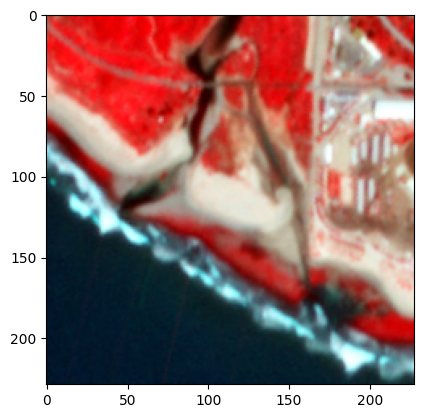

In [399]:
a = top_lap.iloc[197].source_tif
with rasterio.open(a) as src:
    plt.figure()
    plt.imshow(false_color(src.read(), src.read(1, masked=True).mask))

In [187]:
cloudys = []
for (region, year, month, dove), asset_ids in cloudy_downloads.items():
    for asset_id in asset_ids:
        key = (str(year), str(month), str(region), asset_id)
        filename = ff.get(key)
        if filename is None:
            continue
            # print((region, year, month, dove), asset_id)
        cloudys.append({
            "region": int(region),
            "year": int(year),
            "month": int(month),
            "instrument": dove,
            "source_tif": filename,
            "acquired": parse_dt_from_asset_id(asset_id),
            "asset_id": asset_id,
        })

cloudy_labels_df = pd.DataFrame(cloudys)
print(len(cloudy_labels_df))
cloudy_labels_df.head()

101


region  year  month instrument  \
0      39  2018     12       dove   
1      29  2019      1       dove   
2    2161  2018     12       dove   
3      43  2023      2  superdove   
4      88  2018      8       dove   

                                          source_tif            acquired  \
0  /Volumes/x10pro/estuary/ca_all/dove/results/20... 2018-12-09 18:21:18   
1  /Volumes/x10pro/estuary/ca_all/dove/results/20... 2019-01-20 18:16:53   
2  /Volumes/x10pro/estuary/ca_all/dove/results/20... 2018-12-21 18:12:24   
3  /Volumes/x10pro/estuary/ca_all/superdove/resul... 2023-02-21 17:39:23   
4  /Volumes/x10pro/estuary/ca_all/dove/results/20... 2018-08-16 18:33:52   

                  asset_id  
0     20181209_182118_1027  
1     20190120_181653_1038  
2     20181221_181224_1002  
3  20230221_173923_38_2445  
4     20180816_183352_1005

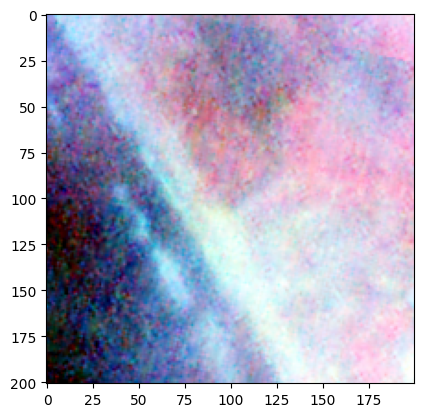

In [203]:
a = cloudy_labels_df.iloc[82].source_tif
with rasterio.open(a) as src:
    plt.figure()
    plt.imshow(false_color(src.read(), src.read(1, masked=True).mask))

In [28]:
ss_df.head()

region                                         source_tif   label  \
0      35  /Volumes/x10pro/estuary/skysat/results/2022/35...  closed   
1      35  /Volumes/x10pro/estuary/skysat/results/2023/35...    open   
2      35  /Volumes/x10pro/estuary/skysat/results/2019/35...    open   
3      35  /Volumes/x10pro/estuary/skysat/results/2019/35...  closed   
4      35  /Volumes/x10pro/estuary/skysat/results/2021/35...  closed   

             acquired instrument  month  year  
0 2022-06-15 18:07:04     skysat      6  2022  
1 2023-04-02 21:21:05     skysat      4  2023  
2 2019-06-08 18:38:26     skysat      6  2019  
3 2019-11-02 21:40:24     skysat     11  2019  
4 2021-05-29 18:42:34     skysat      5  2021

(array([832., 258.,  97.,  33.,   6.,   6.,   3.,   1.,   2.,   1.]),
 array([ 1. ,  1.9,  2.8,  3.7,  4.6,  5.5,  6.4,  7.3,  8.2,  9.1, 10. ]),
 <BarContainer object of 10 artists>)

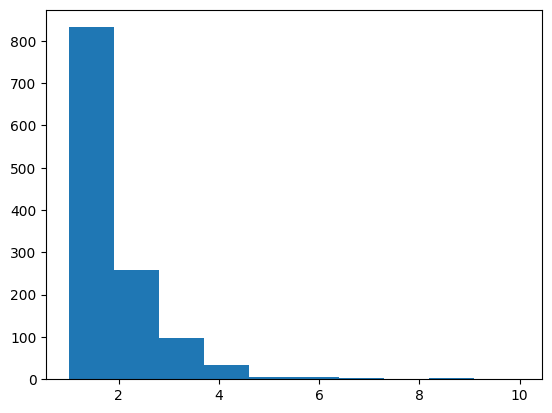

In [17]:
plt.hist([len(v) for v in cloudy_downloads.values()])

In [18]:

for (region, year, month, dove), cloudy in cloudy_downloads.items():
    save_pth = Path("/Volumes/x10pro/estuary/ca_cloudy/") / str(dove) / "results" / str(year) / str(month) / str(region) / "cloudy_images_to_download.csv"
    save_pth.parent.mkdir(exist_ok=True, parents=True)
    df = pd.DataFrame(cloudy, columns=["asset_id"])
    df['include_image'] = True
    df.to_csv(save_pth, index=False)

In [20]:
new_keep

ordered_idx              asset_id  clear_coverge_pct  intersection_pct  \
0             9  20170621_175323_102d             0.9993            1.0000   
1            13  20170625_175354_101f             0.9993            1.0000   
2             4  20170613_175322_100a             0.9993            1.0000   
3             5  20170615_175324_0f15             0.9993            1.0000   
4             0  20170609_175300_1044             0.9993            1.0000   
5            14  20170626_175327_1030             0.9993            1.0000   
6            17  20170627_175422_1031             0.9993            1.0000   
7             2  20170611_175256_0f35             0.0544            0.2404   
8             1  20170611_175255_0f35             0.0314            1.0000   
9             3  20170611_175318_101f             0.0038            1.0000   
10           18  20170628_175919_0e20             0.0000            0.8491   
11            7  20170619_175901_0e14             0.0000            1.0000   
12           19  20170628_175920_0e20             0.0000            1.0000   
13           10  20170621_175812_0e0e             0.9993            1.0000   
14           11  20170625_175312_0f35             0.9993            1.0000   
15           15  20170626_180021_0e16             0.9993            1.0000   
16           12  20170625_175313_0f35             0.9763            0.9582   
17           16  20170627_175421_1031             0.7149            0.7155   
18            8  20170621_175322_102d             0.3323            0.3349   
19            6  20170615_175325_0f15             0.1978            0.1434   

    pct_adding     capture_datetime  include_image  
0      99.9285  2017-06-21 17:53:23           True  
1      99.9285  2017-06-25 17:53:54           True  
2      99.9285  2017-06-13 17:53:22           True  
3      99.9285  2017-06-15 17:53:24           True  
4      99.9285  2017-06-09 17:53:00           True  
5      99.9285  2017-06-26 17:53:27           True  
6      99.9285  2017-06-27 17:54:22           True  
7       5.4447  2017-06-11 17:52:56          False  
8       3.1375  2017-06-11 17:52:55          False  
9       0.3842  2017-06-11 17:53:18          False  
10      0.0000  2017-06-28 17:59:19          False  
11      0.0000  2017-06-19 17:59:01          False  
12      0.0000  2017-06-28 17:59:20          False  
13     99.9285  2017-06-21 17:58:12           True  
14     99.9285  2017-06-25 17:53:12           True  
15     99.9285  2017-06-26 18:00:21           True  
16     97.6251  2017-06-25 17:53:13           True  
17     71.4903  2017-06-27 17:54:21          False  
18     33.2265  2017-06-21 17:53:22          False  
19     19.7806  2017-06-15 17:53:25          False

set()

In [60]:
labels = pd.read_csv(Path("/Volumes/x10pro/estuary/ca_all/dove/labels.csv"))
labels.head()

region                                         source_tif label  \
0      84  /Volumes/x10pro/estuary/ca_all/dove/results/20...  open   
1      84  /Volumes/x10pro/estuary/ca_all/dove/results/20...  open   
2      84  /Volumes/x10pro/estuary/ca_all/dove/results/20...  open   
3      84  /Volumes/x10pro/estuary/ca_all/dove/results/20...  open   
4      84  /Volumes/x10pro/estuary/ca_all/dove/results/20...  open   

              acquired instrument  
0  2017-02-27 18:18:07       dove  
1  2017-03-11 18:18:41       dove  
2  2017-03-29 18:10:56       dove  
3  2017-04-18 18:12:17       dove  
4  2017-04-29 18:12:11       dove

In [211]:
def ccc(pth):
    pth = Path(pth)
    with open(pth.parent.parent / "filtered_search_results.json") as f:
        data = json.load(f)
    dd = next(d for d in data if d["id"] in pth.stem)
    print(dd['properties'])
    return
ccc(labels.source_tif.iloc[0])

{'acquired': '2017-02-27T18:18:07.091735Z', 'anomalous_pixels': 0.01, 'clear_confidence_percent': 79, 'clear_percent': 94, 'cloud_cover': 0.02, 'cloud_percent': 2, 'ground_control': True, 'gsd': 3.9, 'heavy_haze_percent': 0, 'instrument': 'PS2', 'item_type': 'PSScene', 'light_haze_percent': 3, 'pixel_resolution': 3, 'provider': 'planetscope', 'published': '2021-02-08T06:58:37Z', 'publishing_stage': 'finalized', 'quality_category': 'standard', 'satellite_azimuth': 178.3, 'satellite_id': '0e1f', 'shadow_percent': 0, 'snow_ice_percent': 0, 'strip_id': '422881', 'sun_azimuth': 140.2, 'sun_elevation': 34, 'updated': '2023-11-30T16:17:31Z', 'view_angle': 0.1, 'visible_confidence_percent': 59, 'visible_percent': 98}


In [212]:
def scene_clear_percent(pth):
    pth = Path(pth)
    with open(pth.parent.parent / "filtered_search_results.json") as f:
        data = json.load(f)
    dd = next(d for d in data if d["id"] in pth.stem)
    print(dd['properties'])
    return
    return dd["properties"]["clear_percent"]

def scene_visible_percent(pth):
    pth = Path(pth)
    with open(pth.parent.parent / "filtered_search_results.json") as f:
        data = json.load(f)
    dd = next(d for d in data if d["id"] in pth.stem)
    return dd["properties"]["visible_percent"]

labels["scene_visible_percent"] = labels.source_tif.apply(scene_visible_percent)

In [61]:
def add_clear_percent(pth):
    pth = Path(pth)

    key = "_".join(pth.stem.split("_")[:2])
    udm_pth = next(p for p in pth.parent.glob("*udm2_clip.tif") if key in p.stem)

    with rasterio.open(udm_pth) as src:
        data = src.read([1, 7])
    clear = data[0]
    conf = data[-1]
    nodata = conf < 1
    yesdata = ~nodata
    clear[nodata] = 0

    pct = 100 * clear.sum() / yesdata.sum()
    return pct

labels["clear_percent"] = labels.source_tif.apply(add_clear_percent)

In [62]:
labels["unsure"] = labels.label.apply(lambda a: int(a == "unsure"))
labels.head()

region                                         source_tif label  \
0      84  /Volumes/x10pro/estuary/ca_all/dove/results/20...  open   
1      84  /Volumes/x10pro/estuary/ca_all/dove/results/20...  open   
2      84  /Volumes/x10pro/estuary/ca_all/dove/results/20...  open   
3      84  /Volumes/x10pro/estuary/ca_all/dove/results/20...  open   
4      84  /Volumes/x10pro/estuary/ca_all/dove/results/20...  open   

              acquired instrument  clear_percent  unsure  
0  2017-02-27 18:18:07       dove      99.191309       0  
1  2017-03-11 18:18:41       dove     100.000000       0  
2  2017-03-29 18:10:56       dove      18.842843       0  
3  2017-04-18 18:12:17       dove      72.900180       0  
4  2017-04-29 18:12:11       dove     100.000000       0

<Axes: xlabel='clear_percent', ylabel='scene_visible_percent'>

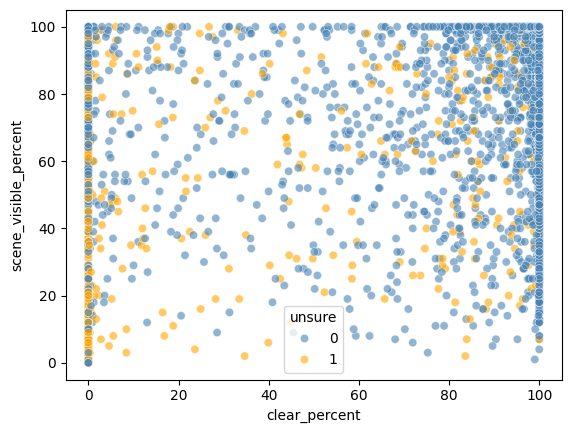

In [213]:
sns.scatterplot(
    data=labels,
    x="clear_percent",
    y="scene_visible_percent",
    hue="unsure",
    palette={0: "steelblue", 1: "orange"},
    alpha=0.6,
)

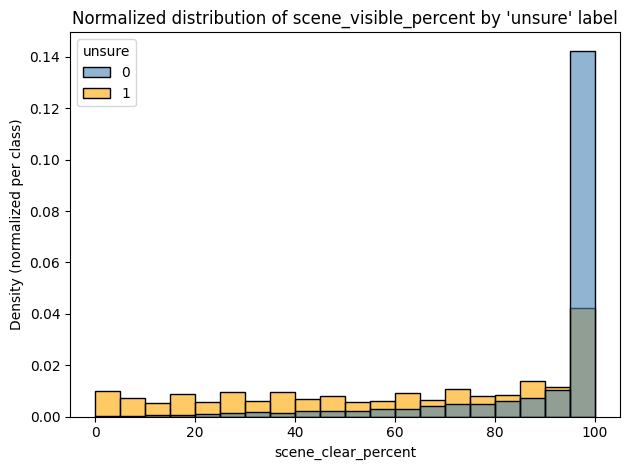

In [214]:
sns.histplot(
    data=labels,
    x="scene_visible_percent",
    hue="unsure",
    bins=20,
    stat="density",  # or "probability"
    common_norm=False,  # don't normalize across classes
    palette={0: "steelblue", 1: "orange"},
    alpha=0.6,
)

plt.xlabel("scene_clear_percent")
plt.ylabel("Density (normalized per class)")
plt.title("Normalized distribution of scene_visible_percent by 'unsure' label")
plt.tight_layout()
plt.show()

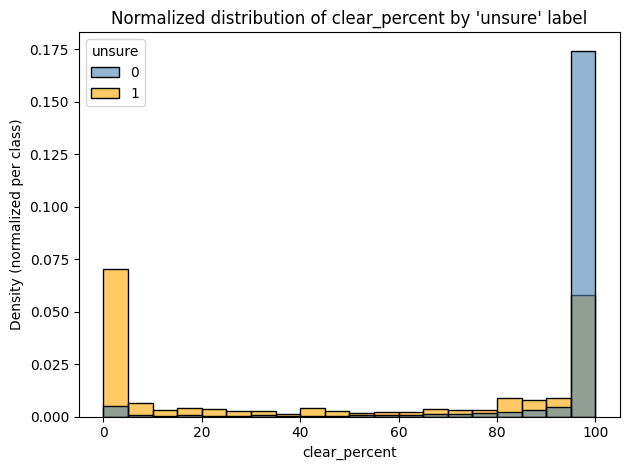

In [63]:
sns.histplot(
    data=labels,
    x="clear_percent",
    hue="unsure",
    bins=20,
    stat="density",  # or "probability"
    common_norm=False,  # don't normalize across classes
    palette={0: "steelblue", 1: "orange"},
    alpha=0.6,
)

plt.xlabel("clear_percent")
plt.ylabel("Density (normalized per class)")
plt.title("Normalized distribution of clear_percent by 'unsure' label")
plt.tight_layout()
plt.show()

<Axes: xlabel='u1', ylabel='unsure_pct'>

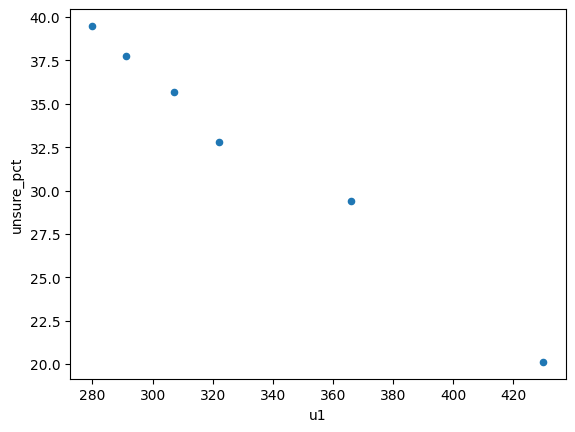

In [274]:
def rrr(lll):
    pcts = []
    # for scene_visible_pct in range(0, 30, 1):
    #     for scene_clear_pct in range(0, 30, 1):
    for clear_pct in range(50, 110, 10):
        cnts0 = len(lll[
            (lll.unsure == 0)
            & (
                # (lll.scene_clear_percent < scene_clear_pct) | 
                (lll.scene_clear_percent < 10)
                | (lll.clear_percent < clear_pct)
            )
        ])
        cnts1 = len(lll[
            (lll.unsure == 1)
            & (
                # (lll.scene_clear_percent < scene_clear_pct) | 
                (lll.scene_clear_percent < 10)
                | (lll.clear_percent < clear_pct)
            )
        ])
        pcts.append({
            # "scene_visible_pct": scene_visible_pct,
            "clear_pct": clear_pct,
            # "scene_clear_pct": scene_clear_pct,
            "u0": cnts0,
            "u1": cnts1,
            "unsure_pct": 100 * cnts1 / max(1, (cnts0 + cnts1))
        })
        
    return pd.DataFrame(pcts)

a = rrr(labels)
a.plot.scatter(y="unsure_pct", x="u1")

In [275]:
a[a.unsure_pct > 30].sort_values(["u1", "unsure_pct"], ascending=False).head(10)

clear_pct   u0   u1  unsure_pct
3         80  659  322   32.823649
2         70  554  307   35.656214
1         60  480  291   37.743191
0         50  429  280   39.492243

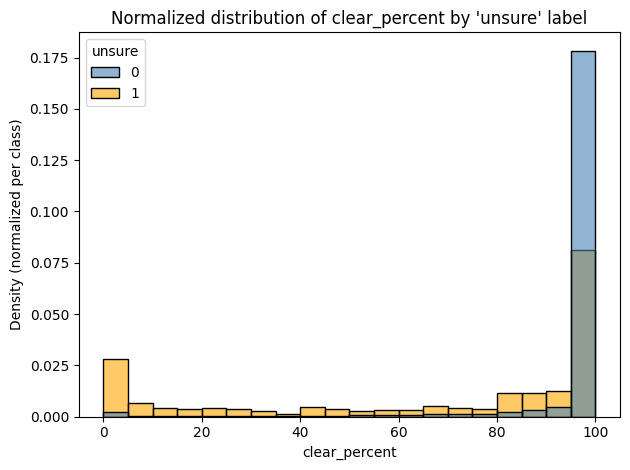

In [283]:
sns.histplot(
    data=labels[
    (labels.scene_clear_percent > 10)
    ],
    x="clear_percent",
    hue="unsure",
    bins=20,
    stat="density",  # or "probability"
    common_norm=False,  # don't normalize across classes
    palette={0: "steelblue", 1: "orange"},
    alpha=0.6,
)

plt.xlabel("clear_percent")
plt.ylabel("Density (normalized per class)")
plt.title("Normalized distribution of clear_percent by 'unsure' label")
plt.tight_layout()
plt.show()

In [ ]:
labels[
    (labels.scene_clear_percent >= 10)
].plot.scatter(x="

20180807_183141_101f_3B_AnalyticMS_SR_clip
region                                                                     84
source_tif                  /Volumes/x10pro/estuary/ca_all/dove/results/20...
label                                                                  closed
acquired                                                  2018-08-07 18:31:41
instrument                                                               dove
clear_percent                                                        0.448887
unsure                                                                      0
scene_cloud_percent                                                        11
scene_clear_percent                                                         2
scene_heavy_haze_percent                                                   23
scene_visible_percent                                                      66
Name: 162, dtype: object


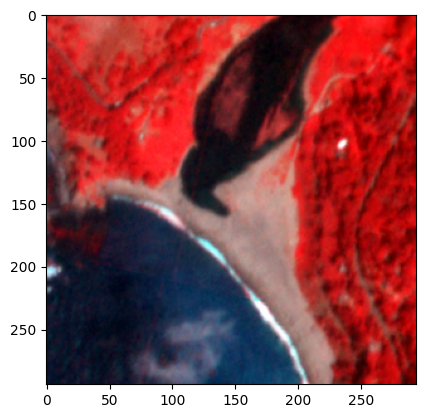

In [282]:
_, row = next(ii)
print(Path(row.source_tif).stem)
print(row)
with rasterio.open(row.source_tif) as src:
    data = src.read(out_dtype=np.float32)
    nodata = ~src.read_masks(1)
    if len(data) == 4:
        img = false_color(data, nodata)
    else:
        img = broad_band(data, nodata)

plt.figure()
plt.imshow(img)

In [24]:
runs = []
base = Path("/Users/kyledorman/data/results/estuary/train")
paths = list(base.glob("20251008*")) + [sorted(list(base.glob("20251006*")))[-1]]
for pth in paths:
    if not (pth / "preds.csv").exists():
        continue
    df = pd.read_csv(pth / "preds.csv")

    with open(pth / "cli_diff.yaml") as f:
        conf = yaml.safe_load(f)
    if "20251003" in pth.name:
        df["smooth_factor"] = 0.0
    else:
        df["smooth_factor"] = conf.get("smooth_factor", 0.0)
    df["perch_smooth_factor"] = conf.get("perch_smooth_factor", 0.0)
    df["epochs"] = conf.get("epochs", 0)
    df["model"] = pth.name
    runs.append(df)

runs_df = pd.concat(runs, ignore_index=True)

runs_df.head()

source_tif  y_true    y_prob  \
0  /Users/kyledorman/data/estuary/dataset/images/...       0  0.000003   
1  /Users/kyledorman/data/estuary/dataset/images/...       0  0.000005   
2  /Users/kyledorman/data/estuary/dataset/images/...       0  0.000010   
3  /Users/kyledorman/data/estuary/dataset/images/...       0  0.000015   
4  /Users/kyledorman/data/estuary/dataset/images/...       0  0.000017   

   y_pred  region  fold orig_label dataset  correct  smooth_factor  \
0       0      65    -1     closed   train     True            0.0   
1       0      65    -1     closed   train     True            0.0   
2       0      65    -1     closed   train     True            0.0   
3       0      65    -1     closed   train     True            0.0   
4       0      65    -1     closed   train     True            0.0   

   perch_smooth_factor  epochs            model  
0                  0.4      30  20251008-151833  
1                  0.4      30  20251008-151833  
2                  0.4      30  20251008-151833  
3                  0.4      30  20251008-151833  
4                  0.4      30  20251008-151833

In [25]:
grouped_results = (
    runs_df.sort_values(by=["region", "epochs", "perch_smooth_factor", "smooth_factor"])
    .groupby(by=["region", "model", "dataset"], as_index=False)
    .correct.mean()
    .rename(columns={"correct": "accuracy"})
)

grouped_results.head()

region            model dataset  accuracy
0      11  20251006-115232    test       1.0
1      11  20251006-115232   train       1.0
2      11  20251006-115232     val       1.0
3      11  20251008-111541    test       1.0
4      11  20251008-111541   train       1.0

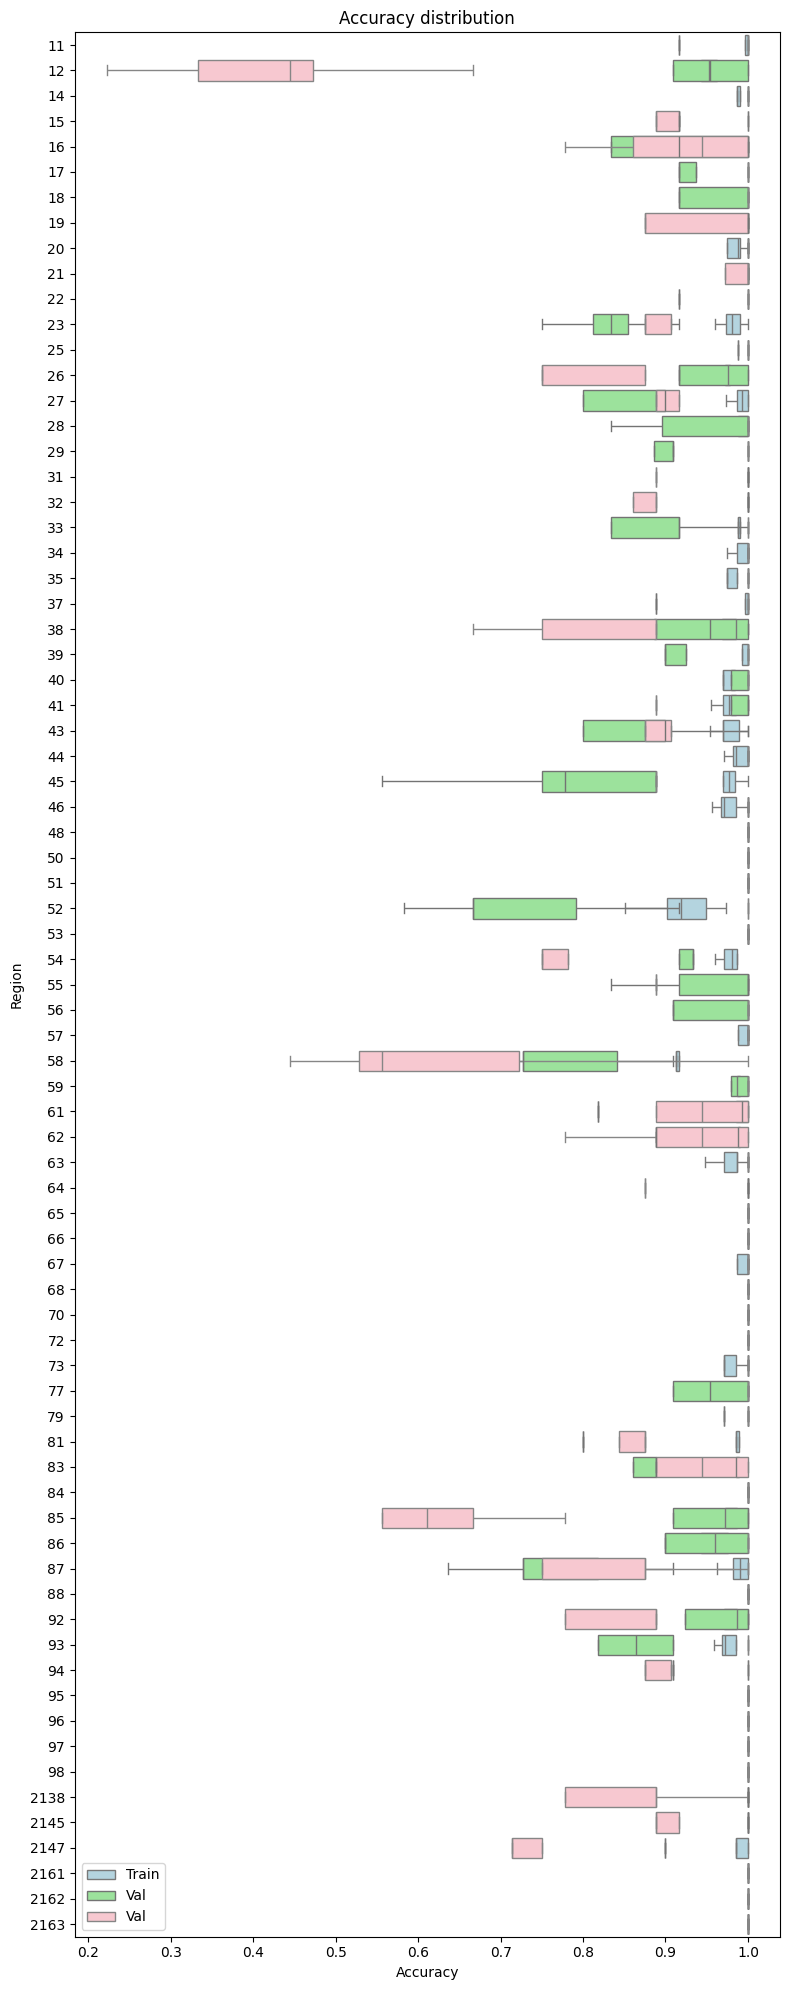

In [26]:
plt.figure(figsize=(8, 20))  # tall plot for 75 regions

df = grouped_results.copy()
df["region"] = df.region.apply(str)

# Boxplots for train per region
sns.boxplot(
    data=df[df["dataset"] == "train"],
    y="region",
    x="accuracy",
    color="lightblue",
    showfliers=False,
    orient="h",
    label="Train",
    # color="lightblue", marker="D", s=30, label="Train"
)

# Overlay val points
sns.boxplot(
    data=df[df["dataset"] == "val"],
    y="region",
    x="accuracy",
    color="lightgreen",
    showfliers=False,
    orient="h",
    label="Val",
    # color="lightblue", marker="D", s=30, label="Train"
)

# Overlay test points
sns.boxplot(
    data=df[df["dataset"] == "test"],
    y="region",
    x="accuracy",
    color="pink",
    showfliers=False,
    orient="h",
    label="Val",
)

plt.title("Accuracy distribution")
plt.xlabel("Accuracy")
plt.ylabel("Region")
plt.legend()
plt.tight_layout()

plt.show()

In [36]:
a = runs_df.groupby("region").correct.mean()
worst_regions = a.sort_values().iloc[:10].index.tolist()
worst_regions

[58, 12, 52, 87, 85, 45, 54, 81, 38, 23]

<Axes: xlabel='accuracy', ylabel='model'>

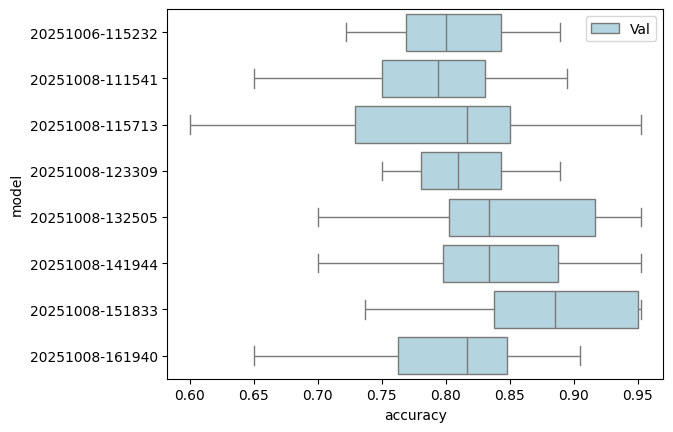

In [43]:
df = (
    runs_df[runs_df.dataset != "train"]
    .groupby(["model", "region"], as_index=False)
    .correct.mean()
    .rename(columns={"correct": "accuracy"})
)
a = df.groupby("region").accuracy.min()
worst_regions = a.sort_values().iloc[:10].index.tolist()

adf = df[df.region.isin(worst_regions)].copy().sort_values("model")
adf["region"] = adf.region.apply(str)

sns.boxplot(
    data=adf,
    y="model",
    x="accuracy",
    color="lightblue",
    showfliers=False,
    orient="h",
    label="Val",
    # color="lightblue", marker="D", s=30, label="Train"
)

# sns.boxplot(
#     data=df[df["dataset"]=="test"],
#     y="model", x="accuracy",
#     color="pink", showfliers=False, orient="h", label="Test"
#     # color="lightblue", marker="D", s=30, label="Train"
# )

# sns.boxplot(
#     data=df[df["dataset"]=="train"],
#     y="model", x="accuracy",
#     color="green", showfliers=False, orient="h", label="Train"
#     # color="lightblue", marker="D", s=30, label="Train"
# )

In [48]:
skipped_regions = pd.read_csv("/Volumes/x10pro/estuary/geos/skipped_regions.csv")[
    "Site code"
].to_list()

gdf = gpd.read_file("/Users/kyledorman/data/estuary/geos/ca_data_w_usgs.geojson")
gdf = gdf[~gdf["Site code"].isin(skipped_regions)].copy()
gdf = gdf.set_index("Site code")
gdf.head()

Latitude  Longitude         Region Nation               Site name  \
Site code                                                                      
11           32.933   -117.260  North America    USA  Los Penasquitos Lagoon   
12           33.166   -117.358  North America    USA      Buena Vista Lagoon   
14           33.203   -117.391  North America    USA      San Luis Rey River   
15           33.231   -117.416  North America    USA   Santa Margarita River   
16           33.291   -117.465  North America    USA         Las Fores Creek   

           Studied (1) / Not Studied (0)  \
Site code                                  
11                                     1   
12                                     0   
14                                     0   
15                                     1   
16                                     0   

                                              station_nm   site_no  \
Site code                                                            
11                                                  None      None   
12                                                  None      None   
14                                                  None      None   
15         SANTA MARGARITA RIVER ESTUARY NR OCEANSIDE CA  11046050   
16           LAS FLORES C LAGOON A MOUTH NR OCEANSIDE CA  11046102   

          site_latitude site_longitude                 geometry  
Site code                                                        
11                 None           None   POINT (-117.26 32.933)  
12                 None           None  POINT (-117.358 33.166)  
14                 None           None  POINT (-117.391 33.203)  
15           33.2294795   -117.4103174  POINT (-117.416 33.231)  
16          33.29055556       -117.465  POINT (-117.465 33.291)

In [89]:
plt.figure()
pth = list(
    Path("/Volumes/x10pro/estuary/skysat/results/").glob("*/43/files/*pansharpened_clip.tif")
)[0]
with rasterio.open(pth) as src:
    data = src.read()
    nodata = src.read(1, masked=True).mask
    img = false_color(data, nodata)
    img = Image.fromarray(img).resize((224, 224))
    # .save("/Users/kyledorman/data/estuary/display/region_53.png")
plt.imshow(img)

IndexError: list index out of range

<Figure size 640x480 with 0 Axes>

In [90]:
with open("/Volumes/x10pro/estuary/dataset/normalization/stats.json") as f:
    stats = json.load(f)

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PowerTransformer, StandardScaler

pt = PowerTransformer(standardize=False)
pt.lambdas_ = np.array(stats["lambdas"])
st = StandardScaler()
st.scale_ = np.array(stats["stds"])
st.mean_ = np.array(stats["means"])

norm = Pipeline([("PowerTransformer", pt), ("StandardScaler", st)])

In [91]:
pth = list(
    Path("/Volumes/x10pro/estuary/skysat/results/").glob("*/43/files/*pansharpened_clip.tif")
)[0]
print(pth)
with open("/Volumes/x10pro/estuary/dataset/normalization/stats.json") as f:
    stats = json.load(f)

plt.figure(figsize=(10, 10))

EIGHT_TO_4 = (7, 5, 3, 1)
with rasterio.open(pth) as src:
    data = src.read(out_dtype=np.float32)
    nodata = src.read(1, masked=True).mask
    rgb = masked_contrast_stretch(data[[2, 1, 0]], ~nodata)
    plt.imshow(rgb.transpose((1, 2, 0)))

    img = np.zeros((8, *data.shape[1:]), dtype=data.dtype)
    for i, b in enumerate(reversed(EIGHT_TO_4)):
        img[b] = data[i]
    shp = img.shape
    img = norm.transform(img.reshape(len(img), -1).T).T.reshape(shp)
    img = np.array([img[i] for i in reversed(EIGHT_TO_4)])

bgrnir = ["B", "G", "R", "NIR"]
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))

for i, ax in enumerate(axes.flatten()):
    ax.axis("off")
    ax.imshow(img[i])
    ax.set_title(bgrnir[i])
fig.tight_layout()
plt.show()

IndexError: list index out of range

/Volumes/x10pro/estuary/dove/results/2022/1/43/files/20220101_180639_73_1067_3B_AnalyticMS_SR_clip.tif


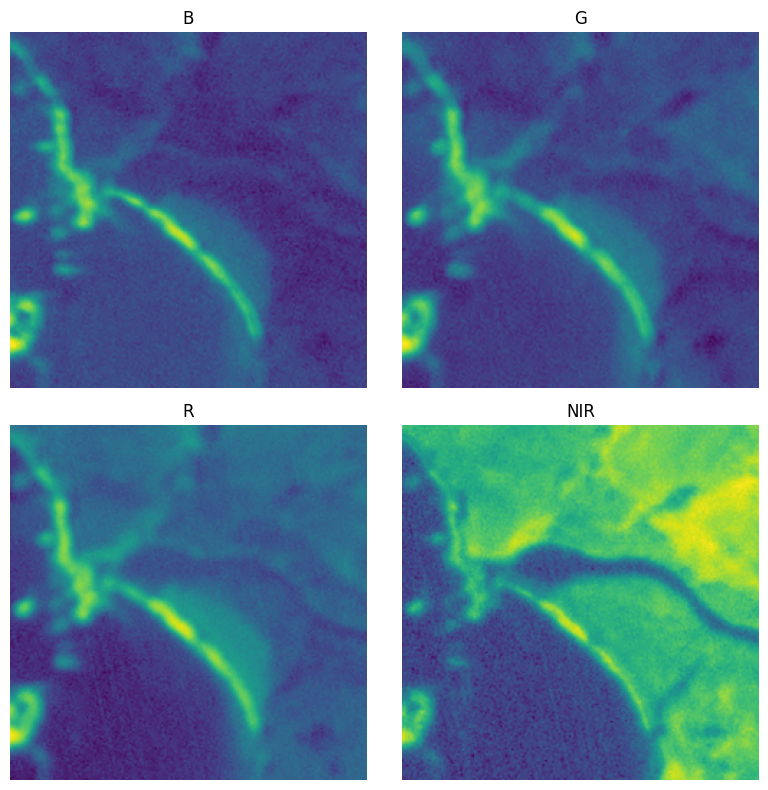

In [94]:
pth = list(Path("/Volumes/x10pro/estuary/dove/results/").glob("*/*/43/files/*SR*clip.tif"))[0]
with open("/Volumes/x10pro/estuary/dataset/normalization/stats.json") as f:
    stats = json.load(f)

print(pth)

# plt.figure()

EIGHT_TO_4 = (7, 5, 3, 1)
with rasterio.open(pth) as src:
    data = src.read(out_dtype=np.float32)
    nodata = src.read(1, masked=True).mask
    rgb = masked_contrast_stretch(data[[2, 1, 0]], ~nodata)
    # plt.imshow(rgb.transpose((1, 2, 0)))

    img = np.zeros((8, *data.shape[1:]), dtype=data.dtype)
    for i, b in enumerate(reversed(EIGHT_TO_4)):
        img[b] = data[i]
    shp = img.shape
    img = norm.transform(img.reshape(len(img), -1).T).T.reshape(shp)
    img = np.array([img[i] for i in reversed(EIGHT_TO_4)])

bgrnir = ["B", "G", "R", "NIR"]
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(8, 8))
for i, ax in enumerate(axes.flatten()):
    ax.axis("off")
    ax.imshow(img[i])
    ax.set_title(bgrnir[i])
fig.tight_layout()
plt.show()

/Volumes/x10pro/estuary/superdove/results/2022/11/43/files/20221102_182420_94_2486_3B_AnalyticMS_SR_8b_clip.tif


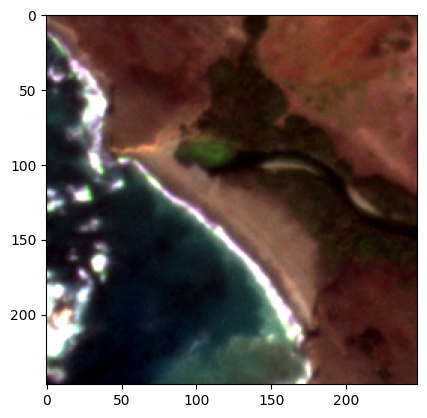

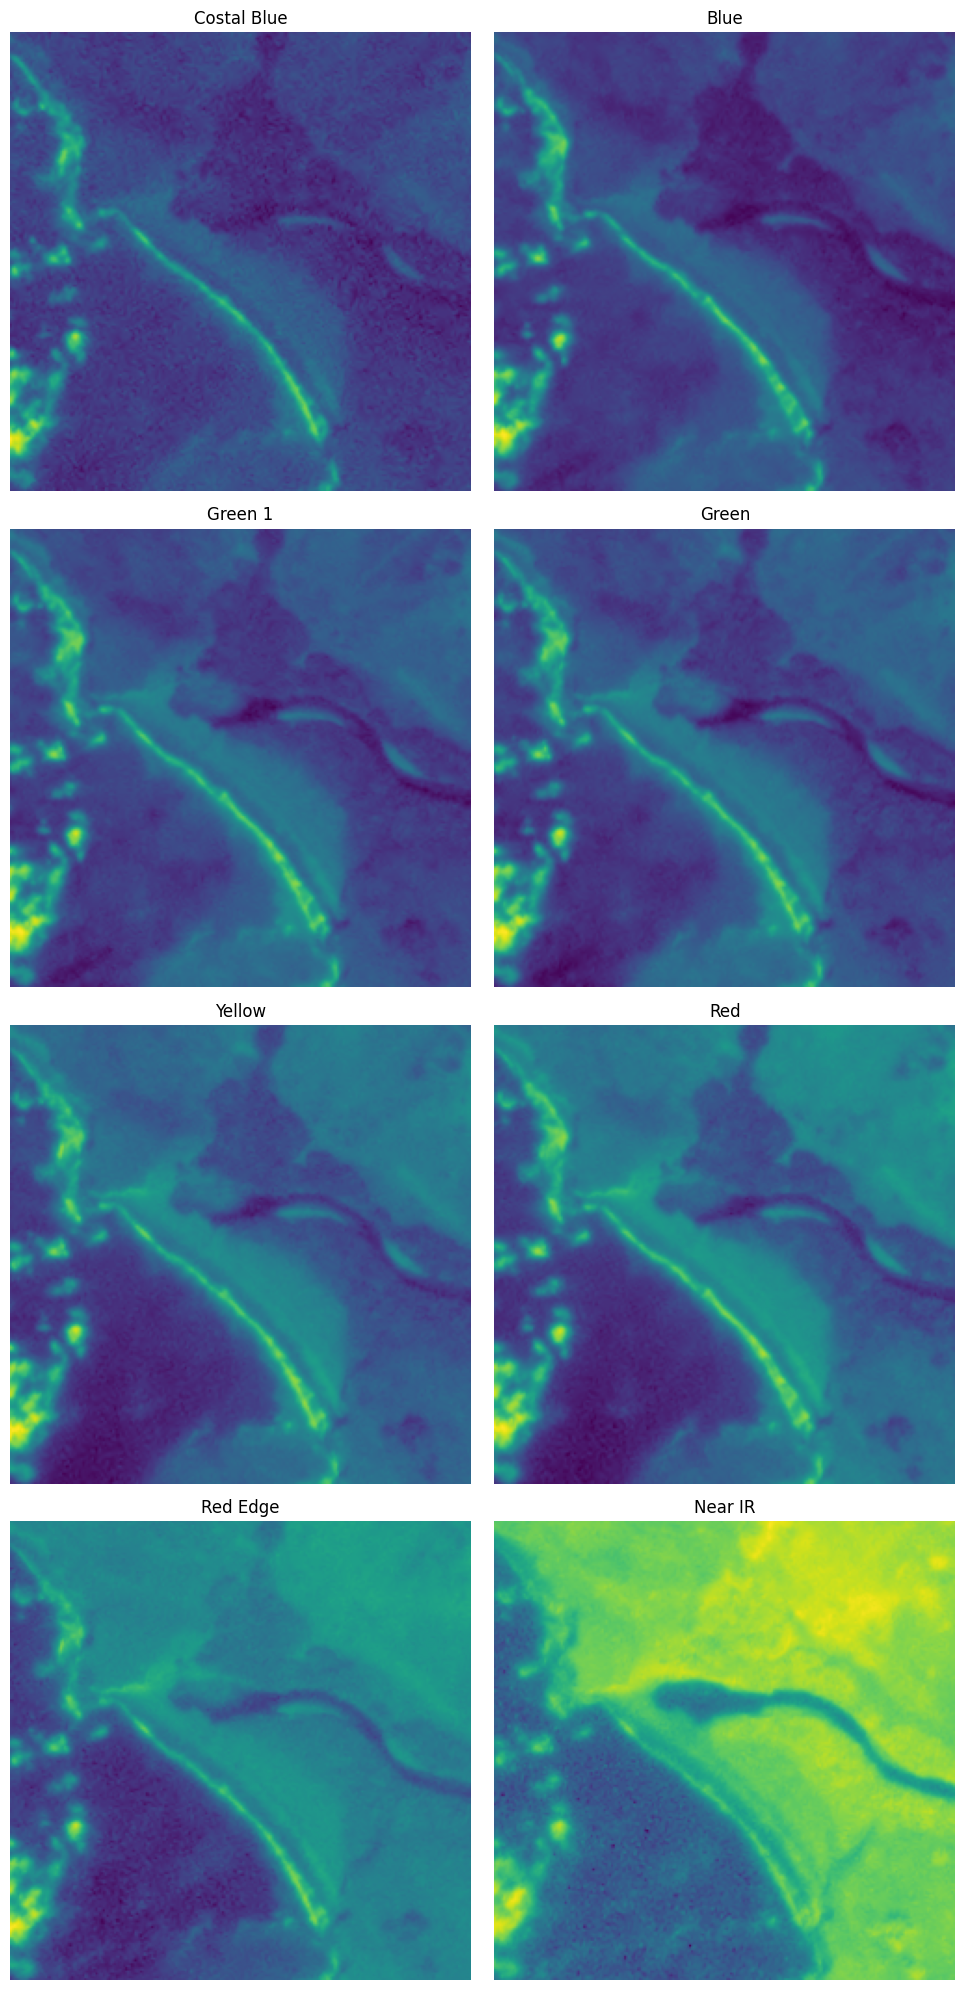

In [97]:
pth = list(Path("/Volumes/x10pro/estuary/superdove/results/").glob("*/*/43/files/*SR*clip.tif"))[1]
with open("/Volumes/x10pro/estuary/dataset/normalization/stats.json") as f:
    stats = json.load(f)

print(pth)

plt.figure()

with rasterio.open(pth) as src:
    img = src.read(out_dtype=np.float32)
    nodata = src.read(1, masked=True).mask
    rgb = masked_contrast_stretch(img[[5, 3, 1]], ~nodata)
    plt.imshow(rgb.transpose((1, 2, 0)))

    shp = img.shape
    img = norm.transform(img.reshape(len(img), -1).T).T.reshape(shp)

from estuary.constants import BAND_NAMES

fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(10, 20))

for i, ax in enumerate(axes.flatten()):
    ax.axis("off")
    ax.imshow(img[i])
    ax.set_title(BAND_NAMES[i])
fig.tight_layout()
plt.show()

In [98]:
contig_preds = pd.read_csv("/Volumes/x10pro/estuary/ca_all/preds.csv")
contig_preds["acquired"] = contig_preds.source_tif.apply(lambda a: parse_dt_from_pth(Path(a)))
contig_preds = contig_preds.sort_values(by=["region", "acquired"])
contig_preds["year"] = contig_preds.acquired.dt.year
contig_preds.head()

source_tif  y_true    y_prob  \
3681  /Volumes/x10pro/estuary/ca_all/dove/results/20...       1  0.998599   
3682  /Volumes/x10pro/estuary/ca_all/dove/results/20...       1  0.997285   
3683  /Volumes/x10pro/estuary/ca_all/dove/results/20...       1  0.997597   
3684  /Volumes/x10pro/estuary/ca_all/dove/results/20...       1  0.999996   
3685  /Volumes/x10pro/estuary/ca_all/dove/results/20...       1  0.999997   

      y_pred  region dataset orig_label  correct            acquired  year  
3681       1      21   train       open     True 2017-01-14 17:55:15  2017  
3682       1      21   train       open     True 2017-01-15 17:55:12  2017  
3683       1      21   train       open     True 2017-01-19 17:54:44  2017  
3684       1      21   train       open     True 2017-02-25 17:55:26  2017  
3685       1      21   train       open     True 2017-03-01 17:56:24  2017

In [105]:
acc_yr = (
    contig_preds.groupby(["year", "region"], as_index=False)
    .correct.mean()
    .rename(columns={"correct": "accuracy"})
)

acc_yr.head()

year  region  accuracy
0  2017      21  0.989247
1  2017      28  0.978495
2  2017      43  0.903846
3  2017      48  1.000000
4  2017      51  1.000000

In [111]:
acc_yr.region.max()

2145

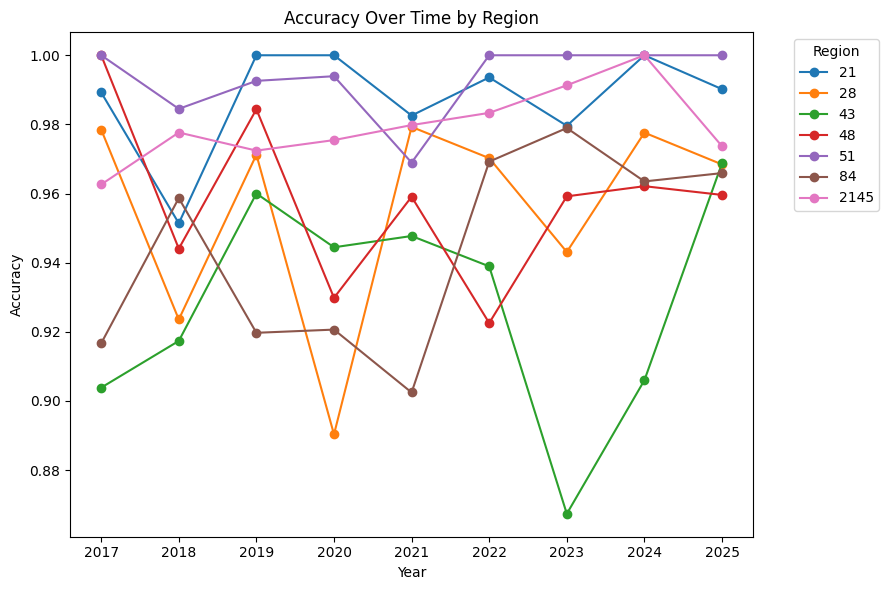

In [113]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(9, 6))

for region, group in acc_yr.groupby("region"):
    group = group.sort_values("year")
    ax.plot(group["year"], group["accuracy"], marker="o", label=region)

ax.set_title("Accuracy Over Time by Region")
ax.set_xlabel("Year")
ax.set_ylabel("Accuracy")
ax.legend(title="Region", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

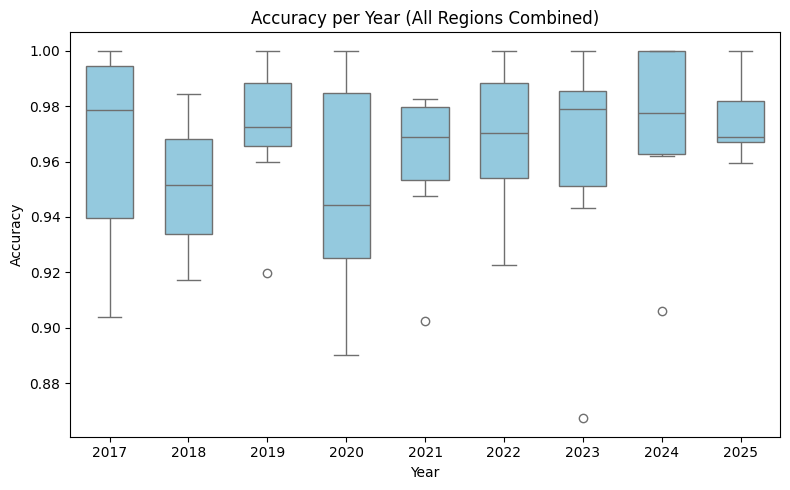

In [108]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 5))
sns.boxplot(data=acc_yr, x="year", y="accuracy", color="skyblue", width=0.6)
plt.title("Accuracy per Year (All Regions Combined)")
plt.xlabel("Year")
plt.ylabel("Accuracy")
plt.tight_layout()
plt.show()